In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt








In [16]:
# Define the date range
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Download the data
df = yf.download('NVDA', START, TODAY)


[*********************100%%**********************]  1 of 1 completed


In [17]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-07-12,128.259995,131.919998,127.220001,129.240005,129.240005,252103100
2024-07-15,130.559998,131.389999,127.180000,128.440002,128.440002,208326200
2024-07-16,128.440002,129.039993,124.580002,126.360001,126.360001,214769500
2024-07-17,121.349998,121.849998,116.720001,117.989998,117.989998,390086200
2024-07-18,121.849998,122.400002,116.559998,121.089996,121.089996,320138200


In [18]:
# Function to add technical indicators
def add_indicators(df):
    # Moving averages
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()
    
    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Moving Average Convergence Divergence (MACD)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    return df

In [19]:
# Add indicators
df = add_indicators(df)

# Add percentage change
df['Pct_Change'] = df['Close'].pct_change()

# Drop NaN values
df = df.dropna()

In [20]:
# Prepare features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA50', 'MA200', 'RSI', 'MACD', 'Signal Line', 'Pct_Change']
X = df[features]
y = df['Close'].shift(-1)  # Predict next day's closing price

# Remove last row (as we don't have the next day's price for it)
X = X[:-1]
y = y[:-1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [21]:
# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

RMSE: 0.9423401609933376


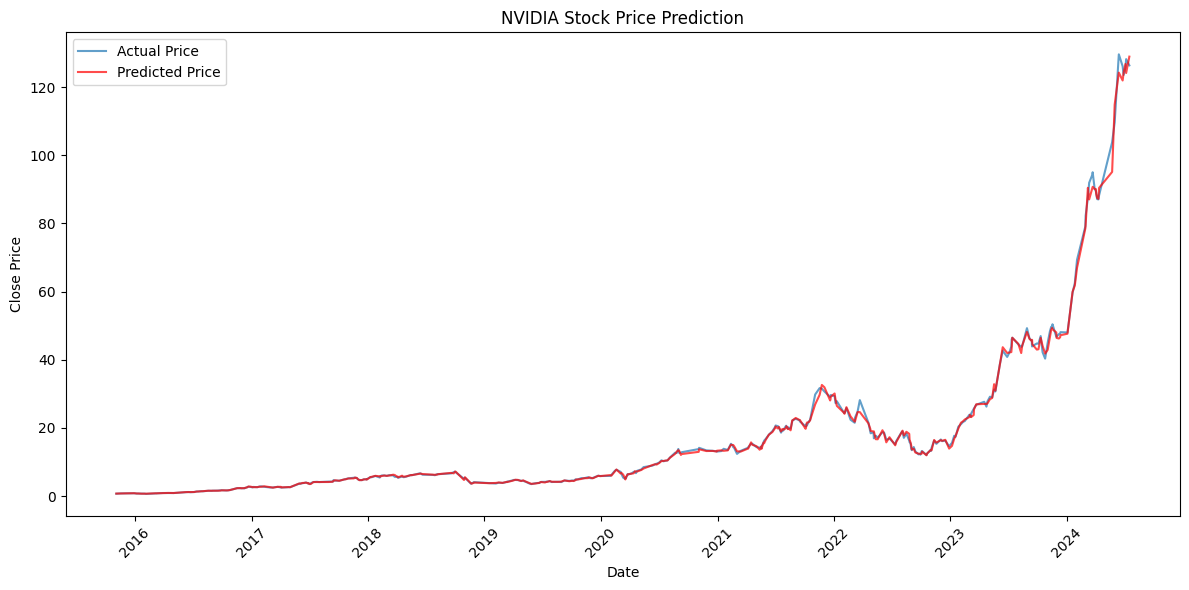

In [22]:
# Convert to DataFrame for easier handling
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}, index=y_test.index)

# Sort the index to ensure chronological order
results = results.sort_index()

# Plot
plt.figure(figsize=(12,6))
plt.plot(results.index, results['Actual'], label='Actual Price', alpha=0.7)
plt.plot(results.index, results['Predicted'], color='red', label='Predicted Price', alpha=0.7)
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Feature importance
importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
importance = importance.sort_values('importance', ascending=False)
print("Feature Importance:")
print(importance)

Feature Importance:
        feature  importance
3         Close    0.239110
1          High    0.226246
2           Low    0.192904
5          MA50    0.130040
0          Open    0.125941
6         MA200    0.084861
9   Signal Line    0.000345
4        Volume    0.000225
8          MACD    0.000146
7           RSI    0.000092
10   Pct_Change    0.000088


In [24]:
# Predict next 30 days
last_30_days = df[features].tail(30)
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 31)]
future_predictions = []


In [25]:
for _ in range(30):
    next_day_pred = model.predict([last_30_days.iloc[-1]])[0]
    future_predictions.append(next_day_pred)
    
    # Update the last_30_days DataFrame for the next prediction
    new_row = last_30_days.iloc[-1].copy()
    new_row['Close'] = next_day_pred
    new_row['Pct_Change'] = (next_day_pred - new_row['Close']) / new_row['Close']
    last_30_days = pd.concat([last_30_days[1:], pd.DataFrame([new_row])])

future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions})
print("\nNext 30 days predictions:")
print(future_df)


Next 30 days predictions:
         Date  Predicted Price
0  2024-07-19       121.488109
1  2024-07-20       121.550008
2  2024-07-21       121.623708
3  2024-07-22       121.623708
4  2024-07-23       121.623708
5  2024-07-24       121.623708
6  2024-07-25       121.623708
7  2024-07-26       121.623708
8  2024-07-27       121.623708
9  2024-07-28       121.623708
10 2024-07-29       121.623708
11 2024-07-30       121.623708
12 2024-07-31       121.623708
13 2024-08-01       121.623708
14 2024-08-02       121.623708
15 2024-08-03       121.623708
16 2024-08-04       121.623708
17 2024-08-05       121.623708
18 2024-08-06       121.623708
19 2024-08-07       121.623708
20 2024-08-08       121.623708
21 2024-08-09       121.623708
22 2024-08-10       121.623708
23 2024-08-11       121.623708
24 2024-08-12       121.623708
25 2024-08-13       121.623708
26 2024-08-14       121.623708
27 2024-08-15       121.623708
28 2024-08-16       121.623708
29 2024-08-17       121.623708


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: Use